In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import re
from ast import literal_eval
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = list(stopwords.words('english'))
rm=re.compile(r'\b'.join(stopword+r' ?\b|\b' for stopword in STOPWORDS)[:-3])
def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ',text)
    text = BAD_SYMBOLS_RE.sub('',text)
    text = rm.sub('',text)
    text = re.sub(r'\s+',' ',text)
    if text[0]==' ':
        text=text[1:]
    if text[-1]==' ':
        text=text[:-1]
    return text

In [3]:
def read_data(filename):
    data = pd.read_csv(filename, sep='\t')
    print(data['tags'].iloc[1])
    data['tags'] = data['tags'].apply(literal_eval)
    return data

In [4]:
train = read_data('data/train.tsv')
train['title'] = train['title'].apply(text_prepare)
train['length'] = train['title'].apply(len)
train = train.sort_values(by=['length'])
validation = read_data('data/validation.tsv')
test = pd.read_csv('data/test.tsv', sep='\t')

['php', 'mysql']
['javascript']


In [5]:
X_train, y_train = train['title'].values, train['tags'].values
X_val, y_val = validation['title'].values, validation['tags'].values
X_test = test['title'].values

In [6]:
max_length=max(max([len(x) for x in X_train]),max([len(x) for x in X_val]),max([len(x) for x in X_test]))
batch_size=100

In [7]:
wordsets={}
X=X_train
for x in X:
    for word in x.split():
        wordsets[word]=1
X=X_val
for x in X:
    for word in x.split():
        wordsets[word]=1
X=X_test
for x in X:
    for word in x.split():
        wordsets[word]=1
wordsets=list(wordsets.keys())
NX=len(wordsets)
wordsets={}
y_train1=y_train
for tag in y_train1:
    for word in tag:
        wordsets[word]=1
y_train1=y_val
for tag in y_train1:
    for word in tag:
        wordsets[word]=1
Ny=len(wordsets.keys())

In [8]:
trbl=10
num_layers=3
state_size=128
num_classes=100
hidden_size=100
p=0.5
num_features=100
max_length=max(max([len(x) for x in X_train]),max([len(x) for x in X_val]),max([len(x) for x in X_test]))
batch_size=100
num_epochs=1000
batches=1000

In [54]:
tf.reset_default_graph()
seln=tf.placeholder(tf.int64,[batch_size])
init_state=tf.placeholder(tf.float32,[num_layers,2,batch_size,state_size])
Batch_X_PlaceHolder=tf.placeholder(tf.float32,[batch_size,max_length,N])
Batch_y_PlaceHolder=tf.placeholder(tf.int32,[batch_size,num_classes])
state_per_layer=tf.unstack(init_state,axis=0)
rnn_tuple_state=tuple(
    [tf.nn.rnn_cell.LSTMStateTuple(state_per_layer[idx][0],state_per_layer[idx][1]) for idx in range(num_layers)]
)
Embd_w=tf.Variable(np.random.rand(N,num_features),dtype=tf.float32)
Embd_b=tf.Variable(np.random.rand(1,num_features),dtype=tf.float32)

NameError: name 'N' is not defined

In [ ]:
sess=tf.Session()
sess.run(tf.initializers.global_variables())
bstate=np.zeros((num_layers,2,batch_size,state_size),np.float32)
for i in range(num_epochs):
    for j in range(batches):
        batchx=X_train[j*batch_size:(j+1)*batch_size]
        batchy=y_train[j*batch_size:(j+1)*batch_size]
        [bstate]=sess.run([bstate],feed_dict={bstate:bstate,Batch_X_PlaceHolder:batchx,Batch_y_PlaceHolder:batchy})

In [55]:
yset={}
for y in y_train:
    for tag in y:
        yset[tag]=1
for y in y_val:
    for tag in y:
        yset[tag]=1
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer()
cv.fit(yset)
y_train_new=[]
for y in y_train:
    y_train_new.append(' '.join(y))
y_val_new=[]


In [10]:
from keras.preprocessing.text import Tokenizer
tokenizer2=Tokenizer(num_words=Ny+1)
tokenizer2.fit_on_texts(list(y_train)+list(y_val))
sequences2=tokenizer2.texts_to_sequences(list(y_train)+list(y_val))
labels=[]
y=list(y_train)+list(y_val)
for tag in sequences2:
    t=np.zeros(Ny)
    for wordid in tag:
        t[sequences2[wordid]]=1
    labels.append(t)

In [13]:
from keras.models import Sequential
from keras.layers import Dense,LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer=Tokenizer(num_words=NX+1)
tokenizer.fit_on_texts(list(X_train)+list(X_val)+list(X_test))
sequences=tokenizer.texts_to_sequences(list(X_train)+list(X_val))
ml=max([len(x) for x in sequences])
X_train_new=pad_sequences(sequences,maxlen=ml)
model=Sequential()
model.add(Embedding(input_dim=NX,output_dim=num_features,input_length=ml,trainable=True,mask_zero=0))
model.add(LSTM(units=state_size,dropout=0.5,recurrent_dropout=0.5,return_sequences=True))
model.add(LSTM(units=state_size,dropout=0.5,recurrent_dropout=0.5,return_sequences=True))
model.add(LSTM(units=state_size,dropout=0.5,recurrent_dropout=0.5))
model.add(Dense(num_classes,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.fit(X_train_new,np.array(labels),validation_split=0.2,epochs=1,batch_size=32)

Train on 104000 samples, validate on 26000 samples
Epoch 1/1
104000/104000 [==============================] - 1483s 14ms/step - loss: 0.0836 - acc: 0.9717 - val_loss: 0.0808 - val_acc: 0.9725


In [ ]:
sequences3=tokenizer.texts_to_sequences(list(X_test))
X_test_new=pad_sequences(sequences3,maxlen=ml)
y_pred=model.predict(X_test_new)
print(y_pred[-1]>0.5)
print(X_test[-1])

In [60]:
z=np.round(y_train[-1],2)
zm=np.log(np.mean(np.exp(z)))
zv=z>zm
zv=zv.map(True:1,False:0)
print(labels[-1])

SyntaxError: invalid syntax (<ipython-input-60-abd551167f63>, line 4)

nosuchmethoderror aopnamespaceutilsregisterautoproxycreatorifnecessary lorg springframework beans factory xml parsercontext ljava lang object v
[0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
[0.   0.21 0.28 0.15 0.13 0.5  0.12 0.12 0.01 0.06 0.04 0.03 0.04 0.02
 0.21 0.   0.01 0.08 0.11 0.01 0.02 0.01 0.01 0.02 0.   0.02 0.01 0.
 0.01 0.01 0.   0.   0.01 0.   0.01 0.   0.   0.01 0.02 0.02 0.   0.02
 0.03 0.   0.02 0.   0.   0.   0.   0.   0.   0.01 0.   0.   0.   0.01
 0.   0.   0.   0.   0.   0.   0.01 0.   0.01 0.1  0.02 0.   0.   0.01
 0.01 0.01 0.   0.   0.   0.   0.   0.   0.01 0.   0.   0.   0.   0.
 0.   0.   0.29 0.   0.   0.   0.01 0.01 0.   0.   0.   0.01 0.   0.
 0.   0.  ]
{'c#': 1, 'javascript': 2, 'java': 3, 'php': 4,

(array([87.,  2.,  5.,  1.,  2.,  2.,  0.,  0.,  0.,  1.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ]),
 <a list of 10 Patch objects>)

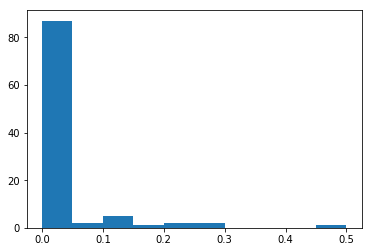

In [40]:
import matplotlib.pyplot as plt
print(X_train[-1])
print(labels[-1])
z=np.round(y_train[-1],2)
print(tokenizer2.word_index)
total=np.sum(np.exp(z))
z1=[zi/total for zi in z]
plt.hist(np.round(y_train[-1],2))